### **Задание №1**. Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [ ]:
SELECT tableName.client_id, tableName.date, 
COALESCE(tableName.value, P.value) value FROM tableName 
JOIN (
    SELECT tableName.client_id, value FROM tableName
    JOIN (
        SELECT client_id, MAX(date) max_date
        FROM tableName
        WHERE value is not NULL
        group by client_id
    ) T
    ON tableName.client_id = T.client_id AND tableName.date = T.max_date
) P
ON tableName.client_id = P.client_id 

### **Задание №1.1 (*)**. В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

In [ ]:
SELECT 
    tableName.client_id, 
    tableName.date, 
    COALESCE(tableName.value,T.value) value
FROM tableName 
LEFT JOIN (
    SELECT T.client_id, T.date, tableName.value
    FROM (
        SELECT tableName.client_id, tableName.date, MAX(T.date) last_known_date FROM tableName
        JOIN (
            SELECT client_id, date, value
            FROM tableName
            WHERE value is not NULL
        ) T 
        ON tableName.client_id = T.client_id 
        AND tableName.date > T.date 
        AND tableName.value is NULL
        GROUP BY tableName.client_id, tableName.date
    ) T
    JOIN tableName 
    ON T.client_id = tableName.client_id
    AND T.last_known_date = tableName.date
) T
ON tableName.client_id = T.client_id
AND tableName.date = T.date

### **Задание №2**. Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

In [1]:
import numpy as np
import pandas as pd

# Сгенерируем данные для задачи
low = 0
high = 5
data = pd.DataFrame(
    np.random.randint(low=low, high=high, size=(500000, 2)),
    columns=['prev_segment', 'new_segment']
)

# <YOUR_CODE_HERE>
data

,prev_segment,new_segment
0,0,2
1,3,3
2,2,2
3,3,4
4,1,3
...,...,...
499995,4,2
499996,1,1
499997,0,4
499998,3,3


Создадим матрицу смен статусов, значения в которой будут равны количеству подобных смен. Проигнорируем диагональные элементы, так как в этом тестовом примере они ненулевые.

In [2]:
result = pd.DataFrame(0, index=np.arange(high), columns=range(low,high))

for i in range(high):
  for j in range(high):
    if i != j:
      result.loc[i,j] = len(data.loc[(data.prev_segment == i)&(data.new_segment == j)])
result

,0,1,2,3,4
0,0,20012,20155,19834,20099
1,19964,0,19880,19900,19951
2,20004,19864,0,19775,19963
3,19898,20117,19936,0,19861
4,20234,20050,20123,20108,0


Остается построчно поделить на элементы на сумму элементов в строке.

In [3]:
result = result.div(result.sum(axis=1), axis='rows')
result

,0,1,2,3,4
0,0.000000,0.249838,0.251623,0.247615,0.250924
1,0.250505,0.000000,0.249451,0.249702,0.250342
2,0.251288,0.249529,0.000000,0.248411,0.250773
3,0.249311,0.252055,0.249787,0.000000,0.248847
4,0.251307,0.249022,0.249929,0.249742,0.000000


### **Задание №2.1 (*)**. Если вы не пользовались библиотечными функциями и реализовывали алгоритм самостоятельно, напишите, пожалуйста, его асимптотическую сложность в терминах O-большое.

In [4]:
# <YOUR_CODE_HERE>

### **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

In [6]:
import numpy as np
import pandas as pd
columns = [
           'Age','Gender','Education','Country',
           'Ethnicity','Nscore','Escore','Oscore','Ascore',
           'Cscore','Impulsive','SS','Alcohol','Amphet',
           'Amyl','Benzos','Caff','Cannabis','Choc',
           'Coke','Crack','Ecstasy','Heroin','Ketamine',
           'Legalh','LSD','Meth','Mushrooms','Nicotine',
           'Semeron','VSA'
           ]
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.columns = columns
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semeron,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Проверим данные на наличие пустых значений в столбцах.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 1 to 1888
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1885 non-null   float64
 1   Gender     1885 non-null   float64
 2   Education  1885 non-null   float64
 3   Country    1885 non-null   float64
 4   Ethnicity  1885 non-null   float64
 5   Nscore     1885 non-null   float64
 6   Escore     1885 non-null   float64
 7   Oscore     1885 non-null   float64
 8   Ascore     1885 non-null   float64
 9   Cscore     1885 non-null   float64
 10  Impulsive  1885 non-null   float64
 11  SS         1885 non-null   float64
 12  Alcohol    1885 non-null   object 
 13  Amphet     1885 non-null   object 
 14  Amyl       1885 non-null   object 
 15  Benzos     1885 non-null   object 
 16  Caff       1885 non-null   object 
 17  Cannabis   1885 non-null   object 
 18  Choc       1885 non-null   object 
 19  Coke       1885 non-null   object 
 20  Crack   

В данных среди прочих наркотиков присутствует  Semeron. Это выдуманный наркотик. Его предназначение в рамках эксперимента  заключается в отсеивании участников, дающих ложные ответы.

Оставим только те строки, в которых в столбце Semeron значение 'CL0'.

In [8]:
data = data.loc[data['Semeron'] == 'CL0']
data = data.set_index(pd.Index(range(1,len(data)+1)))
data = data.drop(columns=['Semeron'])

In [9]:
features = [
           'Age','Gender','Education','Country',
           'Ethnicity','Nscore','Escore','Oscore','Ascore',
           'Cscore','Impulsive','SS'
           ]
drugs = [
           'Alcohol','Amphet',
           'Amyl','Benzos','Caff','Cannabis','Choc',
           'Coke','Crack','Ecstasy','Heroin','Ketamine',
           'Legalh','LSD','Meth','Mushrooms','Nicotine','VSA'
           ]

Проверим, есть ли среди фичей сильно коррелирующие и в случае чего избавимся от них.

In [10]:
data.loc[:, features].corr()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
Age,1.000000,0.110546,0.156719,0.352023,-0.068967,-0.137952,-0.031433,-0.226795,0.063937,0.184265,-0.191432,-0.331521
Gender,0.110546,1.000000,0.197904,0.218806,-0.002845,0.072980,0.058690,-0.133809,0.219119,0.182411,-0.169518,-0.246434
Education,0.156719,0.197904,1.000000,0.223474,-0.035493,-0.102268,0.119156,0.059153,0.089528,0.241438,-0.131714,-0.128587
Country,0.352023,0.218806,0.223474,1.000000,-0.126974,-0.135600,0.111731,-0.340646,0.152536,0.214892,-0.230975,-0.343111
Ethnicity,-0.068967,-0.002845,-0.035493,-0.126974,1.000000,0.048206,0.018086,0.085041,-0.041652,-0.032151,0.085264,0.102193
Nscore,-0.137952,0.072980,-0.102268,-0.135600,0.048206,1.000000,-0.431535,0.007530,-0.217776,-0.392354,0.173384,0.078152
Escore,-0.031433,0.058690,0.119156,0.111731,0.018086,-0.431535,1.000000,0.244784,0.158082,0.307570,0.113695,0.208322
Oscore,-0.226795,-0.133809,0.059153,-0.340646,0.085041,0.007530,0.244784,1.000000,0.036846,-0.058607,0.275363,0.419486
Ascore,0.063937,0.219119,0.089528,0.152536,-0.041652,-0.217776,0.158082,0.036846,1.000000,0.245438,-0.229945,-0.208319
Cscore,0.184265,0.182411,0.241438,0.214892,-0.032151,-0.392354,0.307570,-0.058607,0.245438,1.000000,-0.336175,-0.230334


Так как большинство столбцов в нашем датасете либо категориальные, либо ординальные, приведем их к более удобному виду. Категориальные заменим на столбцы по количеству категорий, где в соответствущем категории столбце будет либо 0, либо 1. Ординальные оставим как есть, так как в этом датасете они уже расположены по порядку.

In [11]:
data.Gender = pd.get_dummies(data.Gender)
data = pd.get_dummies(
    data, 
    columns = ['Country', 'Ethnicity'])

Для начала сведем задачу к multilabel binary classification

#### Multilabel binary classification

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns[~data.columns.isin(drugs)]], 
    data[drugs], 
    test_size=0.25, 
    random_state=1)

In [13]:
multiclass2binary = {
    'CL0': 0,
    'CL1': 0,
    'CL2': 1,
    'CL3': 1,
    'CL4': 1,
    'CL5': 1,
    'CL6': 1
}

y_train_binary = y_train.apply(lambda col: col.apply(lambda row: multiclass2binary[row]))
y_test_binary = y_test.apply(lambda col: col.apply(lambda row: multiclass2binary[row]))

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, accuracy_score

def fitClassifiers(classifiers, X_train, X_test, y_train, y_test):
    roc_auc_scores = {}
    accuracy_scores = {}
    
    for classifier in classifiers:
        model_name = type(classifier).__name__
        
        classifier.fit(X_train, y_train)
        probs = classifier.predict_proba(X_test)
        pred = classifier.predict(X_test)
        accuracy = {}
        method_auc = {}
        if pd.DataFrame(y_test).shape[1] > 1:
          for i in range(len(probs)):
            score = roc_auc_score(y_test.iloc[:,i], probs[i][:,1])
            acc = accuracy_score(y_test.iloc[:,i], pred[:,i])
            method_auc[y_test_binary.columns[i]] = score
            accuracy[y_test_binary.columns[i]] = acc
        else:
          score = roc_auc_score(y_test, probs[:,1])
          method_auc = score
          acc = accuracy_score(y_test, pred)
          accuracy = acc

        roc_auc_scores[model_name] = method_auc
        accuracy_scores[model_name] = accuracy
    
    return classifiers, roc_auc_scores, accuracy_scores

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

classifiers_binary = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

In [16]:
classifiers_binary, roc_auc_scores_binary, accuracy_scores_binary = fitClassifiers(
    classifiers_binary, 
    X_train, 
    X_test, 
    y_train_binary, 
    y_test_binary)

Функция fitClassifiers() возвращает обученные классификаторы, ROC_AUC и точность. Если посмотреть на точность складывается ощущение, что модель в некоторых случаях хорошо работает. Однако показатели ROC_AUC низкие. Связанно это с тем, что данные не сбалансированные.

In [17]:
accuracy_scores_binary

{'DecisionTreeClassifier': {'Alcohol': 0.9446808510638298,
  'Amphet': 0.6574468085106383,
  'Amyl': 0.6723404255319149,
  'Benzos': 0.6361702127659574,
  'Caff': 0.9723404255319149,
  'Cannabis': 0.7446808510638298,
  'Choc': 0.9638297872340426,
  'Coke': 0.6127659574468085,
  'Crack': 0.8340425531914893,
  'Ecstasy': 0.6404255319148936,
  'Heroin': 0.8446808510638298,
  'Ketamine': 0.7404255319148936,
  'LSD': 0.7063829787234043,
  'Legalh': 0.6851063829787234,
  'Meth': 0.7319148936170212,
  'Mushrooms': 0.6595744680851063,
  'Nicotine': 0.6702127659574468,
  'VSA': 0.7957446808510639},
 'ExtraTreesClassifier': {'Alcohol': 0.9659574468085106,
  'Amphet': 0.7297872340425532,
  'Amyl': 0.8191489361702128,
  'Benzos': 0.7,
  'Caff': 0.9893617021276596,
  'Cannabis': 0.8021276595744681,
  'Choc': 0.9744680851063829,
  'Coke': 0.7021276595744681,
  'Crack': 0.8914893617021277,
  'Ecstasy': 0.7702127659574468,
  'Heroin': 0.8978723404255319,
  'Ketamine': 0.8319148936170213,
  'LSD': 0.81

In [18]:
roc_auc_scores_binary

{'DecisionTreeClassifier': {'Alcohol': 0.5214598997493735,
  'Amphet': 0.6241182230570933,
  'Amyl': 0.5235737222772426,
  'Benzos': 0.6267277141600871,
  'Caff': 0.5903225806451613,
  'Cannabis': 0.697449537122946,
  'Choc': 0.5351164483260553,
  'Coke': 0.5755639402791302,
  'Crack': 0.5883288876409751,
  'Ecstasy': 0.6198974180983784,
  'Heroin': 0.6157593678801687,
  'Ketamine': 0.5517072213500784,
  'LSD': 0.6382276165190424,
  'Legalh': 0.6739687055476529,
  'Meth': 0.5984356430170531,
  'Mushrooms': 0.6433977471544556,
  'Nicotine': 0.6140567584961282,
  'VSA': 0.5058050383351588},
 'ExtraTreesClassifier': {'Alcohol': 0.6361998746867168,
  'Amphet': 0.7770628084970325,
  'Amyl': 0.7412742714804477,
  'Benzos': 0.7398822382381617,
  'Caff': 0.846236559139785,
  'Cannabis': 0.8864044040329065,
  'Choc': 0.609443231441048,
  'Coke': 0.7567145407335281,
  'Crack': 0.8019561046375592,
  'Ecstasy': 0.8231137077958389,
  'Heroin': 0.8168839982548839,
  'Ketamine': 0.7671866823652538,
 

Теперь переопределим задачу и попробуем обойти дисбаланс в данных. Попробуем по фичамм предсказать, принимает ли человек запрещенные вещества. 

Для этого подготовим данные. 

In [19]:
illegal_drugs = [
           'Amphet',
           'Amyl','Benzos','Cannabis',
           'Coke','Crack','Ecstasy','Heroin','Ketamine',
           'Legalh','LSD','Meth','Mushrooms','VSA'
           ]

def zeroOrOne(x):
  if x == 0:
    return 0
  else:
    return 1

y_test_addicted = y_test_binary.loc[:, illegal_drugs].sum(axis=1).apply(zeroOrOne)
y_train_addicted = y_train_binary.loc[:, illegal_drugs].sum(axis=1).apply(zeroOrOne)

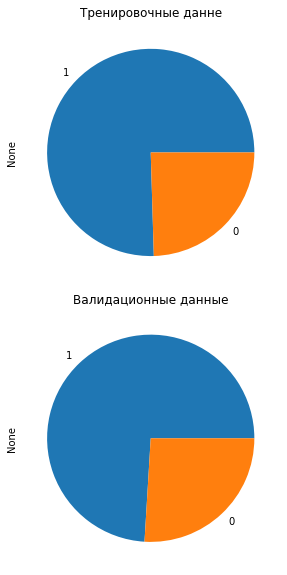

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 20])
plt.subplot(5, 1, 1)
y_train_addicted.value_counts().plot.pie()
plt.title("Тренировочные данне")
plt.subplot(5, 1, 2)
y_test_addicted.value_counts().plot.pie()
plt.title("Валидационные данные")

plt.tight_layout()
plt.show()

На графиках видно, что данные разбалансированны (1:3). Применим две техники борьбы с этой проблемой

#### Oversampling

In [21]:
X_train_oversampled = X_train.append(X_train.loc[y_train_addicted == 0], ignore_index=True)
y_train_addicted_oversampled = y_train_addicted.append(y_train_addicted.loc[y_train_addicted == 0], ignore_index=True)

In [22]:
classifiers_addicted_oversampled = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

classifiers_addicted_oversampled, roc_auc_scores_addicted_oversampled, accuracy_addicted_oversampled = fitClassifiers(
    classifiers_addicted_oversampled, 
    X_train_oversampled, 
    X_test, 
    y_train_addicted_oversampled, 
    y_test_addicted)

In [23]:
roc_auc_scores_addicted_oversampled

{'DecisionTreeClassifier': 0.6986527228189183,
 'ExtraTreesClassifier': 0.8672508008290937,
 'RandomForestClassifier': 0.8847277181081591}

In [24]:
accuracy_addicted_oversampled

{'DecisionTreeClassifier': 0.774468085106383,
 'ExtraTreesClassifier': 0.8085106382978723,
 'RandomForestClassifier': 0.8212765957446808}

#### Undesampling

In [25]:
X_train_undersampled = X_train.loc[y_train_addicted == 0]
X_train_undersampled = X_train_undersampled.append(X_train.loc[y_train_addicted == 1].sample(len(X_train_undersampled)))
y_train_addicted_undersampled = pd.Series([i//(len(X_train_undersampled)/2) for i in range(len(X_train_undersampled))])

In [26]:
classifiers_addicted_undersampled = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

classifiers_addicted_undersampled, roc_auc_scores_addicted_undersampled, accuracy_addicted_undersampled = fitClassifiers(
    classifiers_addicted_undersampled, 
    X_train_undersampled, 
    X_test, 
    y_train_addicted_undersampled, 
    y_test_addicted)

In [27]:
roc_auc_scores_addicted_undersampled

{'DecisionTreeClassifier': 0.700207273412474,
 'ExtraTreesClassifier': 0.8679691916336914,
 'RandomForestClassifier': 0.8662850951573393}

In [28]:
accuracy_addicted_undersampled

{'DecisionTreeClassifier': 0.725531914893617,
 'ExtraTreesClassifier': 0.7659574468085106,
 'RandomForestClassifier': 0.7829787234042553}

Oversampling показал себя лучше. Попробуем на oversampling данных обучить более мощную модель.

#### LightGBM

In [29]:
from lightgbm import LGBMClassifier

In [30]:
LGBM, roc_auc_scores_addicted_oversampled_LGBM, accuracy_addicted_oversampled_LGBM = fitClassifiers(
    [LGBMClassifier()], 
    X_train_oversampled, 
    X_test, 
    y_train_addicted_oversampled, 
    y_test_addicted)

In [31]:
roc_auc_scores_addicted_oversampled_LGBM

{'LGBMClassifier': 0.8729508196721312}

In [32]:
accuracy_addicted_oversampled_LGBM

{'LGBMClassifier': 0.825531914893617}

#### Feature importances

<BarContainer object of 24 artists>

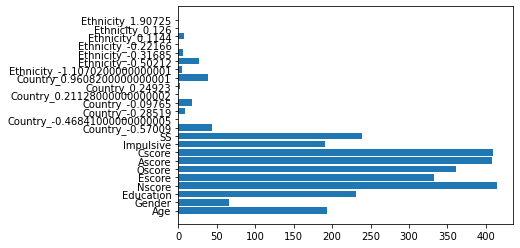

In [33]:
plt.barh(X_test.columns, LGBM[0].feature_importances_)

На графике выше можно заметить, что все свойства кроме пола, страны и расы. Попробуем обучить нашу лучшую модель (LightGBM) без этих полей.

In [34]:
LGBM_no_ecg, roc_auc_scores_addicted_oversampled_LGBM_no_ecg, accuracy_addicted_oversampled_LGBM_no_ecg = fitClassifiers(
    [LGBMClassifier()], 
    X_train_oversampled[[
           'Age','Education',
           'Nscore','Escore','Oscore','Ascore',
           'Cscore','Impulsive','SS'
           ]], 
    X_test[[
           'Age','Education',
           'Nscore','Escore','Oscore','Ascore',
           'Cscore','Impulsive','SS'
           ]], 
    y_train_addicted_oversampled, 
    y_test_addicted)

In [35]:
roc_auc_scores_addicted_oversampled_LGBM_no_ecg

{'LGBMClassifier': 0.85048049745619}

In [36]:
accuracy_addicted_oversampled_LGBM_no_ecg

{'LGBMClassifier': 0.8021276595744681}

Вышло хуже(

#### Наоборот

Порешаем обратные задачи

Попробуем определить пол наркомана по предпочитаемым наркотикам.

In [37]:
drugs2Gender, drugs2Gender_ROC_AUC, drugs2Gender_Accuracy= fitClassifiers(
    [LGBMClassifier()],
    y_train_binary,
    y_test_binary,
    X_train['Gender'],
    X_test['Gender']
    )

In [38]:
drugs2Gender_ROC_AUC

{'LGBMClassifier': 0.6756827731092436}

In [39]:
drugs2Gender_Accuracy

{'LGBMClassifier': 0.625531914893617}

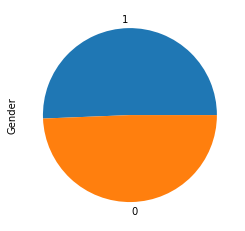

In [40]:
X_test['Gender'].value_counts().plot.pie()

Попробуем определить страну по предпочитаемым наркотикам



In [41]:
reverse_data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
reverse_data.columns = columns
reverse_data.head()

reverse_data = reverse_data.loc[reverse_data['Semeron'] == 'CL0']
reverse_data = reverse_data.set_index(pd.Index(range(1,len(reverse_data)+1)))
reverse_data = reverse_data.drop(columns=['Semeron'])

In [42]:
X_train_reverse, X_test_reverse, y_train_reverse, y_test_reverse = train_test_split(
    reverse_data[drugs], 
    reverse_data[reverse_data.columns[~reverse_data.columns.isin(drugs)]], 
    test_size=0.25, 
    random_state=1)

In [43]:
X_train_reverse = X_train_reverse.apply(lambda col: col.apply(lambda row: multiclass2binary[row]))
X_test_reverse = X_test_reverse.apply(lambda col: col.apply(lambda row: multiclass2binary[row]))

In [44]:
y_test_reverse_country = pd.cut(
    y_test_reverse.Country, 
    bins=[-1, -0.56009,-0.40841, -0.27519, -0.08765, 0.22128,0.25923,0.97082],
    labels=[0,1,2,3,4,5,6])

y_train_reverse_country = pd.cut(
    y_train_reverse.Country, 
    bins=[-1, -0.56009,-0.40841, -0.27519, -0.08765, 0.22128,0.25923,0.97082],
    labels=[0,1,2,3,4,5,6])

In [45]:
drugs2Country = LGBMClassifier()
drugs2Country.fit(X_train_reverse, y_train_reverse_country)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [46]:
accuracy_score(y_test_reverse_country, drugs2Country.predict(X_test_reverse))

0.7148936170212766

Получим неплохой скор для многоклассовой классификации.

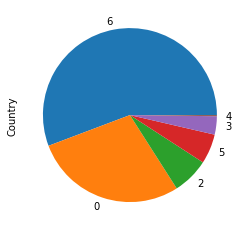

In [47]:
y_test_reverse_country.value_counts().plot.pie()

<BarContainer object of 18 artists>

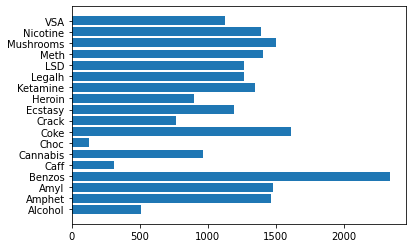

In [48]:
plt.barh(X_train_reverse.columns, drugs2Country.feature_importances_)

### **Задание №4**. Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.

В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [49]:
import numpy as np

# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

Хочется проверить, является ли различие средних в данном примере статистические значимым. Так как данные не являются нормально распределенными, нельзя использовать t-тест Стьюдента. Тогда воспользуемся U-критерием Манна — Уитни. В результате мы выясним, принадлежат ли наши выборки одному распределению. В случае, если принадлежат, можно утверждать, что отличие средних не является статистически значимым.


In [50]:
from scipy import stats

statistic, p_val = stats.mannwhitneyu(control,test)

In [51]:
alpha = 0.01

if p_val > alpha:
  print('Принадлежат одному распределению. Разница средних не значима.')
else:
  print('Не принадлежат одному распределению. Рекомендательная система эффективна.')

Не принадлежат одному распределению. Рекомендательная система эффективна.


### **Задание №4 (*)**. В прошлом задании мы улавливали статистически значимое различие в средних в 0.04 единицы на выборке из 100000 клиентов. Насколько больше нам требуется собрать клиентов, чтобы уловить различие в 0.02?

In [52]:
# <YOUR_CODE_HERE>